In [1]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import PhenomA as pa
import LISA as li
import WaveformTools as wt

# Setup LISA object, load sky & polarization averaged transfer function, plot sensitivity curve


### LISA object options

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Tobs, default=4 yr ---- example: lisa = li.LISA(Tobs=li.YEAR)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Larm, default=2.5e9 (meters)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; NC,   default=2 (number of data channels, 1 or 2)

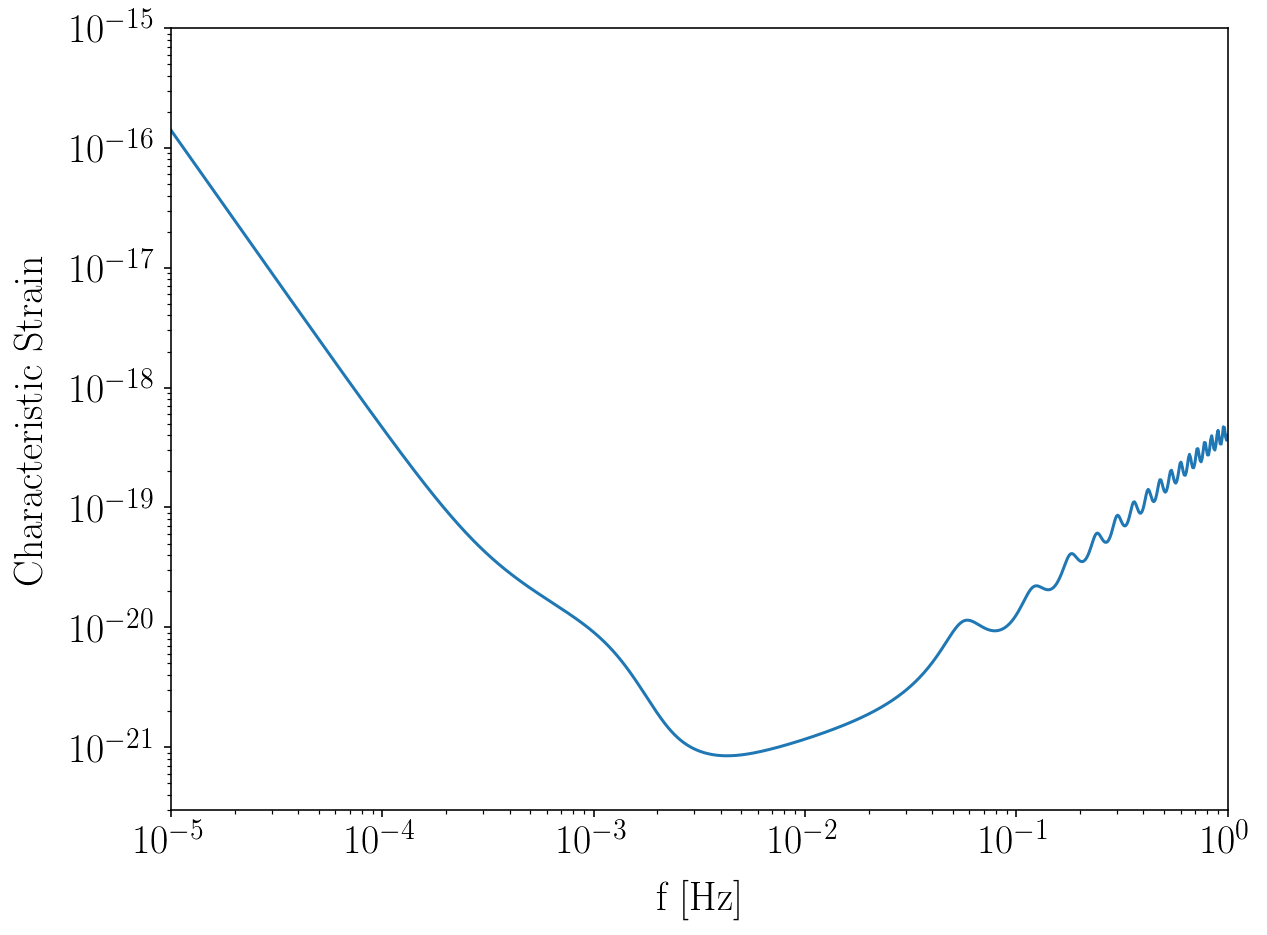

In [2]:
# create LISA object
lisa = li.LISA() 

# Plot LISA's sensitivity curve
f  = np.logspace(np.log10(1.0e-5), np.log10(1.0e0), 1000)
Sn = lisa.Sn(f)
li.PlotSensitivityCurve(f, Sn) # provide additional argument, e.g. 'SensitivityCurve.pdf', to save figure

# Setup Binary Parameters and create a binary object

Redshift provided. 
	Luminosity Distance........... 25924.151861680206 Mpc

SNR........ 2642.6034036915967


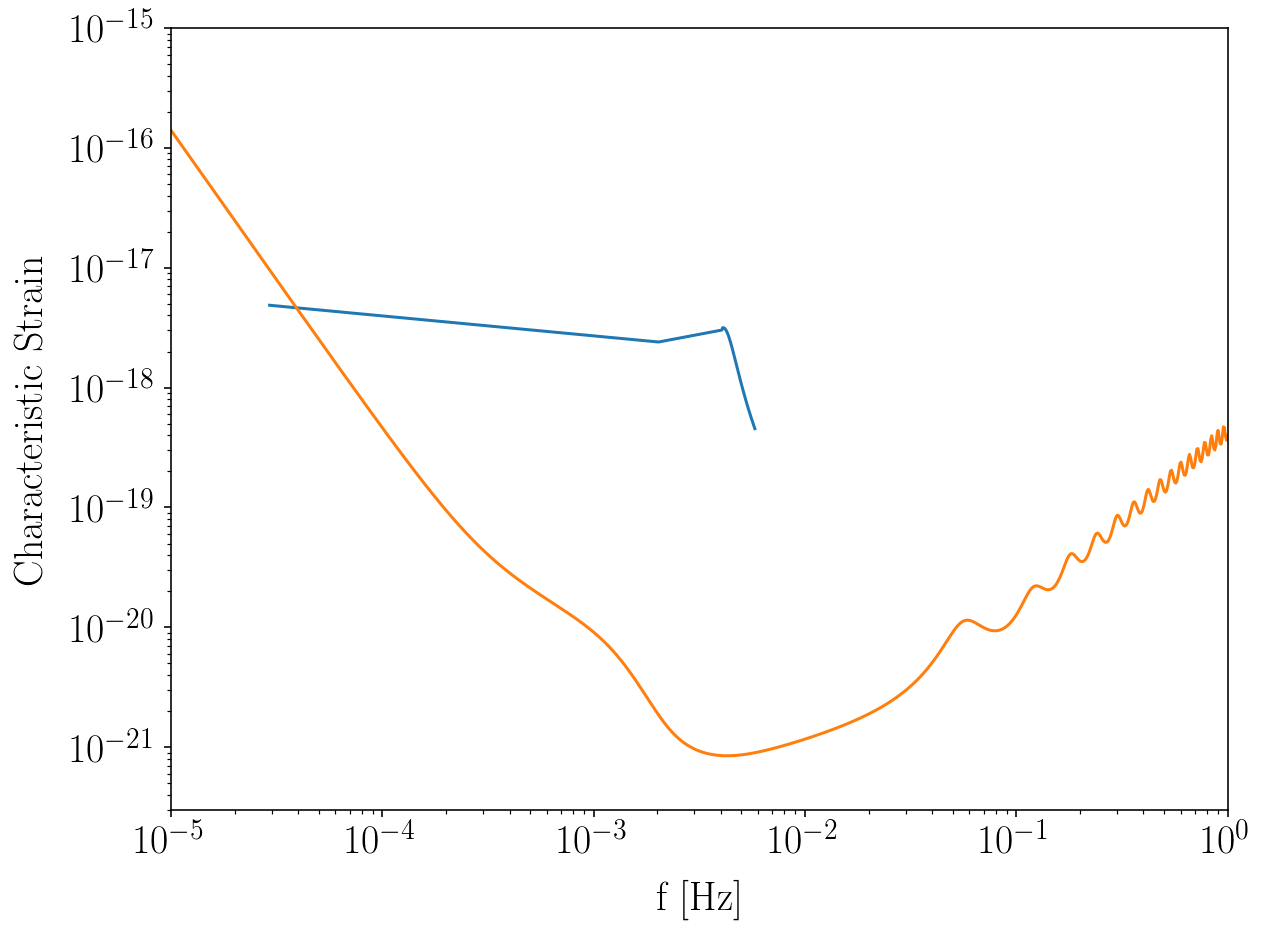

In [3]:
m1 = 0.5e6*pa.TSUN 
m2 = 0.5e6*pa.TSUN
z = 3.0
T_merge = 1.*li.YEAR

binary = wt.Binary(m1, m2, z=z)
binary.T_merge = T_merge
binary.SetFreqBounds(lisa)

freqs, X_char = binary.CalcStrain(lisa)
snr = binary.CalcSNR(freqs, X_char, lisa)
print("\nSNR........ {}".format(snr))
binary.PlotStrain(freqs, X_char, lisa)

Redshift provided. 
	Luminosity Distance........... 25924.151861680206 Mpc

SNR........ 3106.382444968881


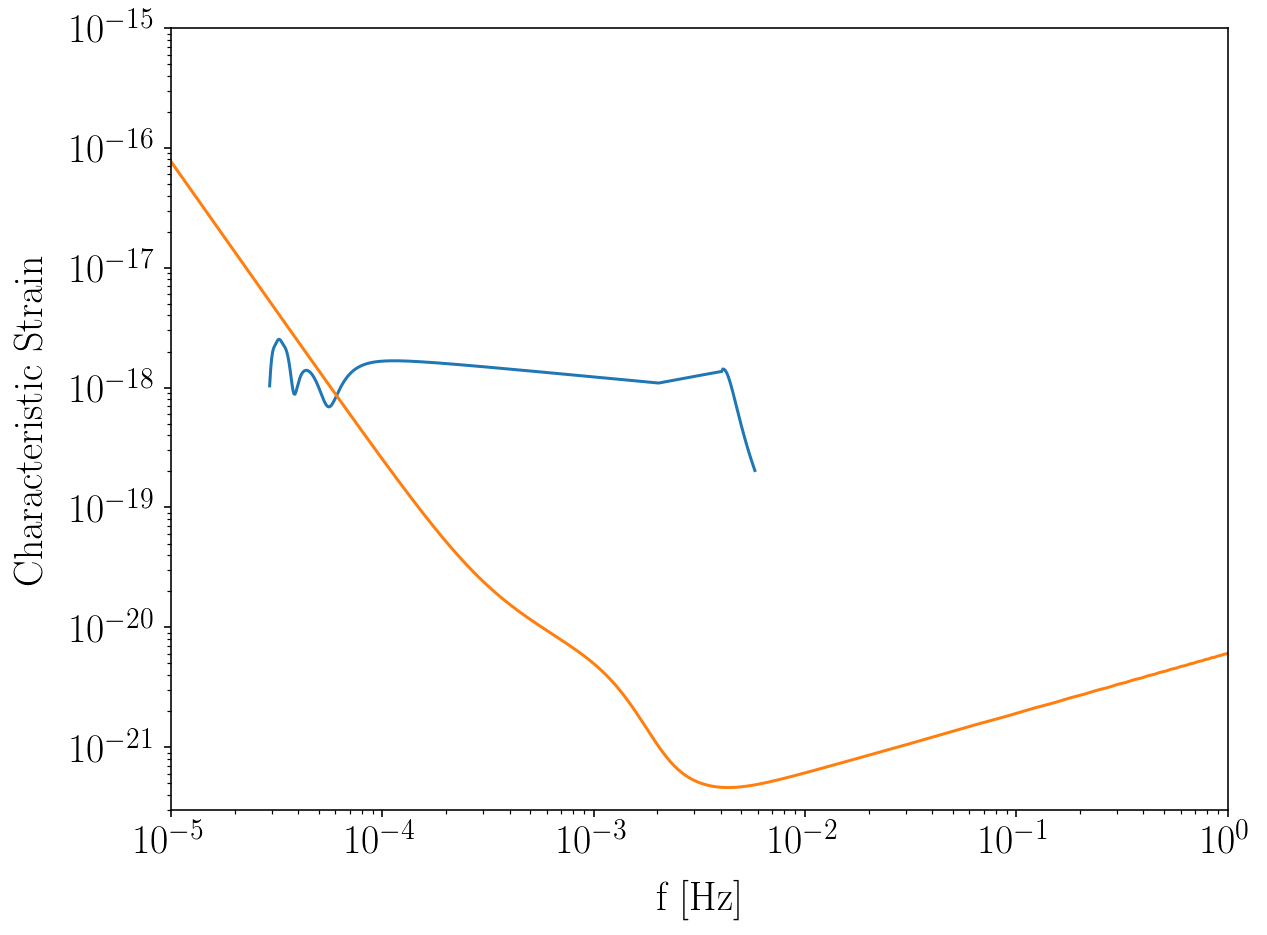

In [4]:
m1 = 0.5e6*pa.TSUN 
m2 = 0.5e6*pa.TSUN
z = 3.0
T_merge = 1.*li.YEAR

binary = wt.Binary(m1, m2, z=z)
binary.T_merge = T_merge
binary.SetFreqBounds(lisa)

freqs, X_char = binary.CalcStrain(lisa, 0.5, 2.3)
snr = binary.CalcSNR(freqs, X_char, lisa)
print("\nSNR........ {}".format(snr))
binary.PlotStrain(freqs, X_char, lisa)

# Check numerically that analytic averaging was successful

In [5]:
num = 50
theta_arr = np.linspace(-1, 1, num)
phi_arr = np.linspace(0, 2*np.pi, num)

tot = 0.0

why = np.zeros(num**2)

for i in range(num):
    theta = np.arccos(theta_arr[i])
    for j in range(num):
        phi = phi_arr[j]
        freqs, X_char = binary.CalcStrain(lisa, theta, phi)
        snr = binary.CalcSNR(freqs, X_char, lisa)
        
        tot += snr**2
        
        why[i*num + j] = snr**2

avg_snr = np.sqrt(tot/num**2)
print(avg_snr)

2644.044958544498


# LIGO Binary

Luminosity Distance provided. 
	redshift........... 0.08891326018535295

SNR........ 4.666592661632494


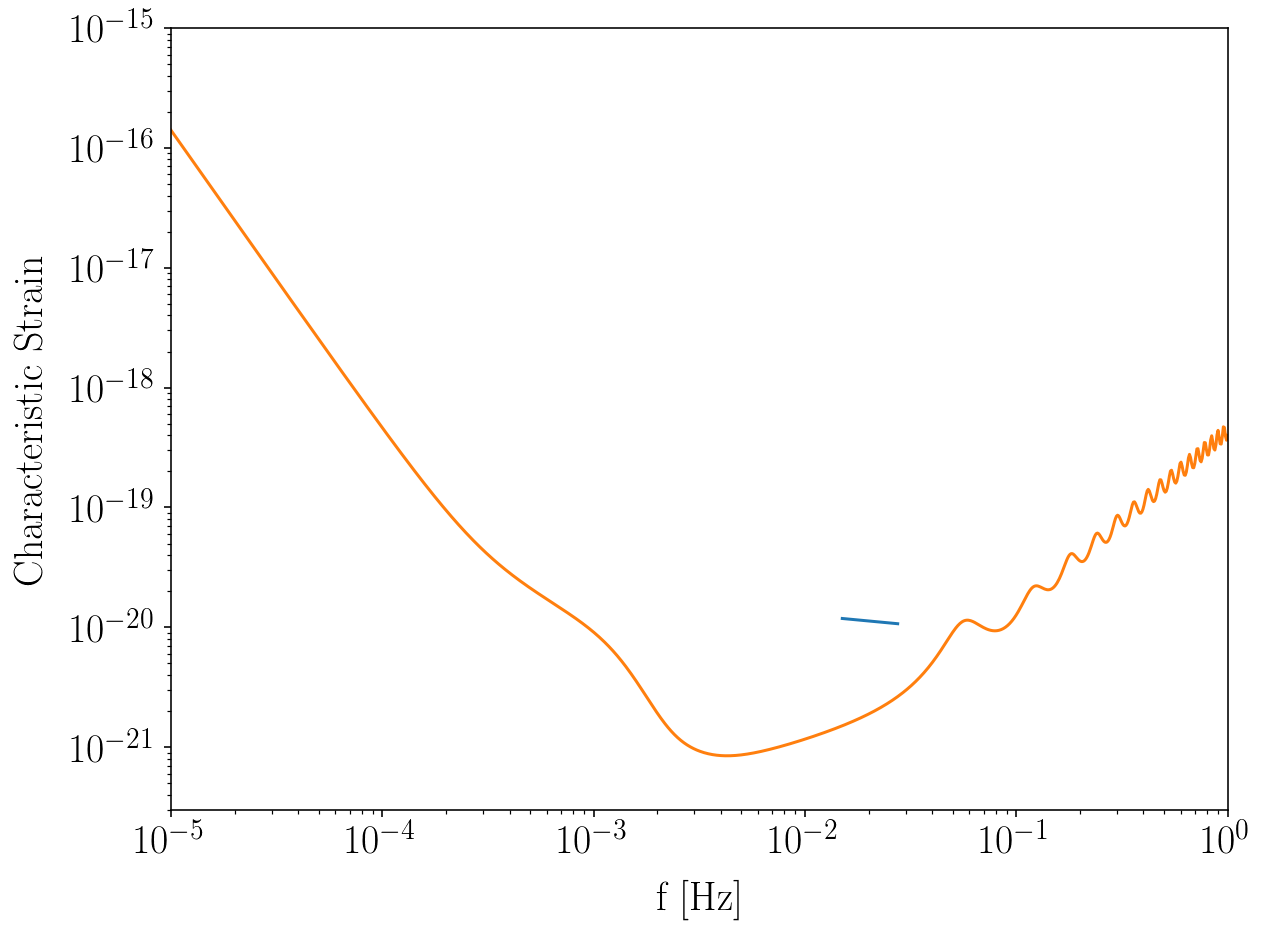

In [6]:
m1 = 36.0*pa.TSUN 
m2 = 29.0*pa.TSUN
Dl = 410.*wt.MPC
T_merge = 5.*li.YEAR

binary = wt.Binary(m1, m2, Dl=Dl)
binary.T_merge = T_merge
binary.SetFreqBounds(lisa)

freqs, X_char = binary.CalcStrain(lisa)
snr = binary.CalcSNR(freqs, X_char, lisa)
print("\nSNR........ {}".format(snr))
binary.PlotStrain(freqs, X_char, lisa)

Luminosity Distance provided. 
	redshift........... 0.08891326018535295

SNR........ 4.657418386475239


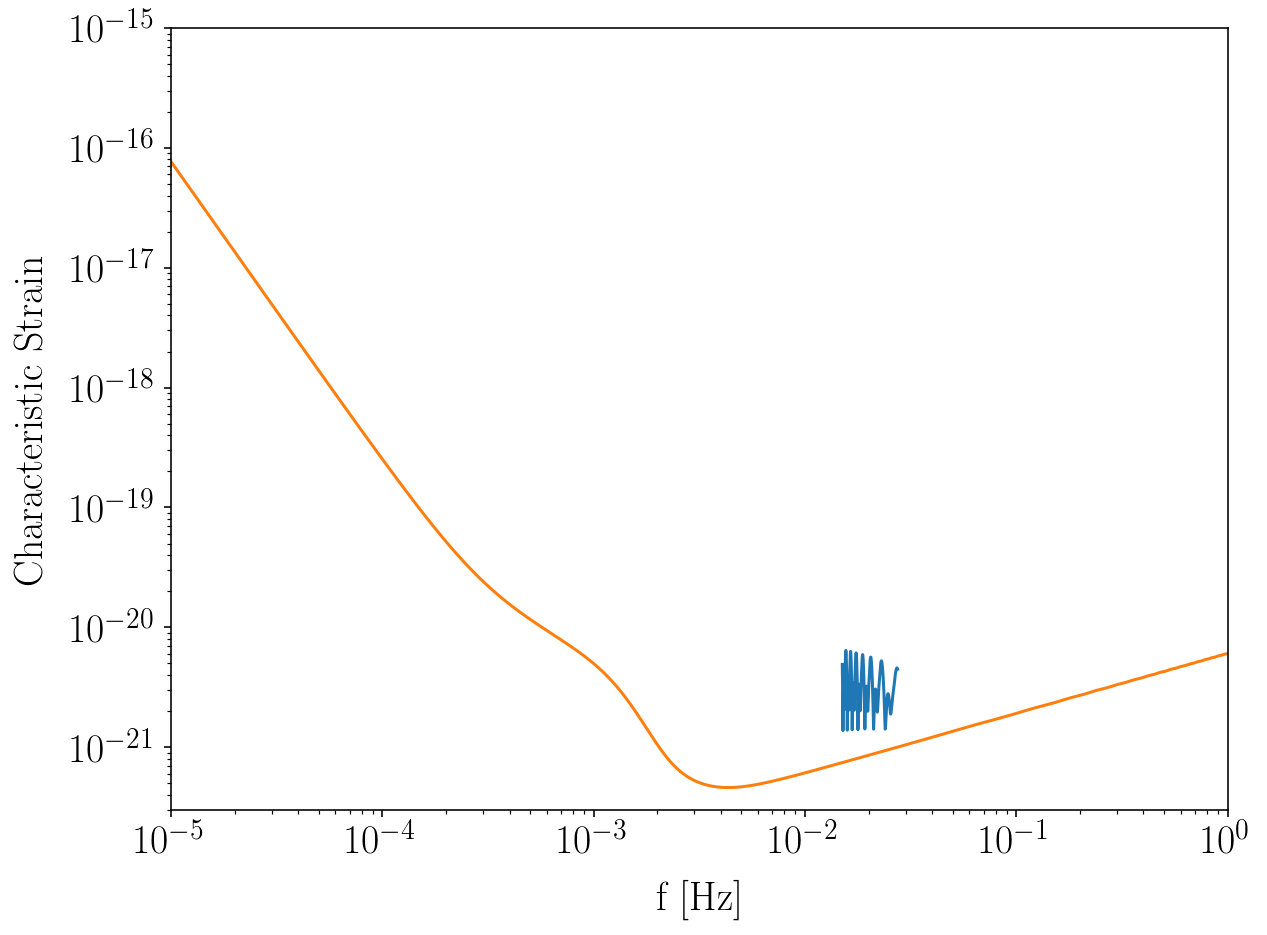

In [7]:
m1 = 36.0*pa.TSUN 
m2 = 29.0*pa.TSUN
Dl = 410.*wt.MPC
T_merge = 5.*li.YEAR

binary = wt.Binary(m1, m2, Dl=Dl)
binary.T_merge = T_merge
binary.SetFreqBounds(lisa)

freqs, X_char = binary.CalcStrain(lisa, 1.1, 1.5)
snr = binary.CalcSNR(freqs, X_char, lisa)
print("\nSNR........ {}".format(snr))
binary.PlotStrain(freqs, X_char, lisa)

In [8]:
num = 50
theta_arr = np.linspace(-1, 1, num)
phi_arr = np.linspace(0, 2*np.pi, num)

tot = 0.0

why = np.zeros(num**2)

for i in range(num):
    theta = np.arccos(theta_arr[i])
    for j in range(num):
        phi = phi_arr[j]
        freqs, X_char = binary.CalcStrain(lisa, theta, phi)
        snr = binary.CalcSNR(freqs, X_char, lisa)
        
        tot += snr**2
        
        why[i*num + j] = snr**2

avg_snr = np.sqrt(tot/num**2)
print(avg_snr)

4.648594412935976


# Galactic Binary

Luminosity Distance provided. 
	redshift........... 2.3117351864949706e-07

SNR........ 139.70704772165996


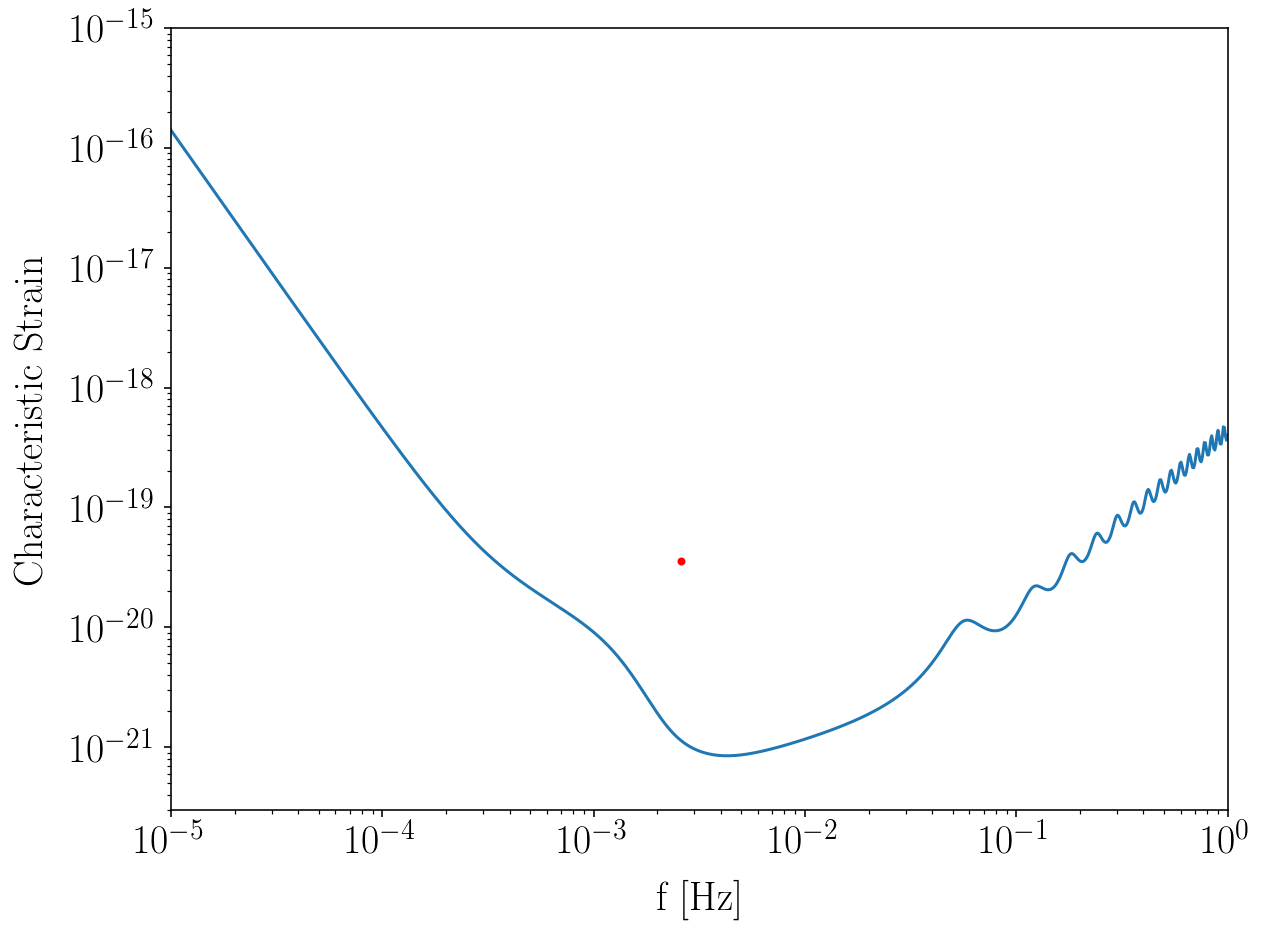

In [9]:
m1 = 0.50*pa.TSUN 
m2 = 0.25*pa.TSUN
Dl = 1.0e-3*wt.MPC
f_start  = 2.6e-3

binary = wt.Binary(m1, m2, Dl=Dl)
binary.f_start = f_start
binary.SetFreqBounds(lisa)

freqs, X_char = binary.CalcStrain(lisa)
snr = binary.CalcSNR(freqs, X_char, lisa)
print("\nSNR........ {}".format(snr))
binary.PlotStrain(freqs, X_char, lisa)

Luminosity Distance provided. 
	redshift........... 2.3117351864949706e-07

SNR........ 212.4515139611185


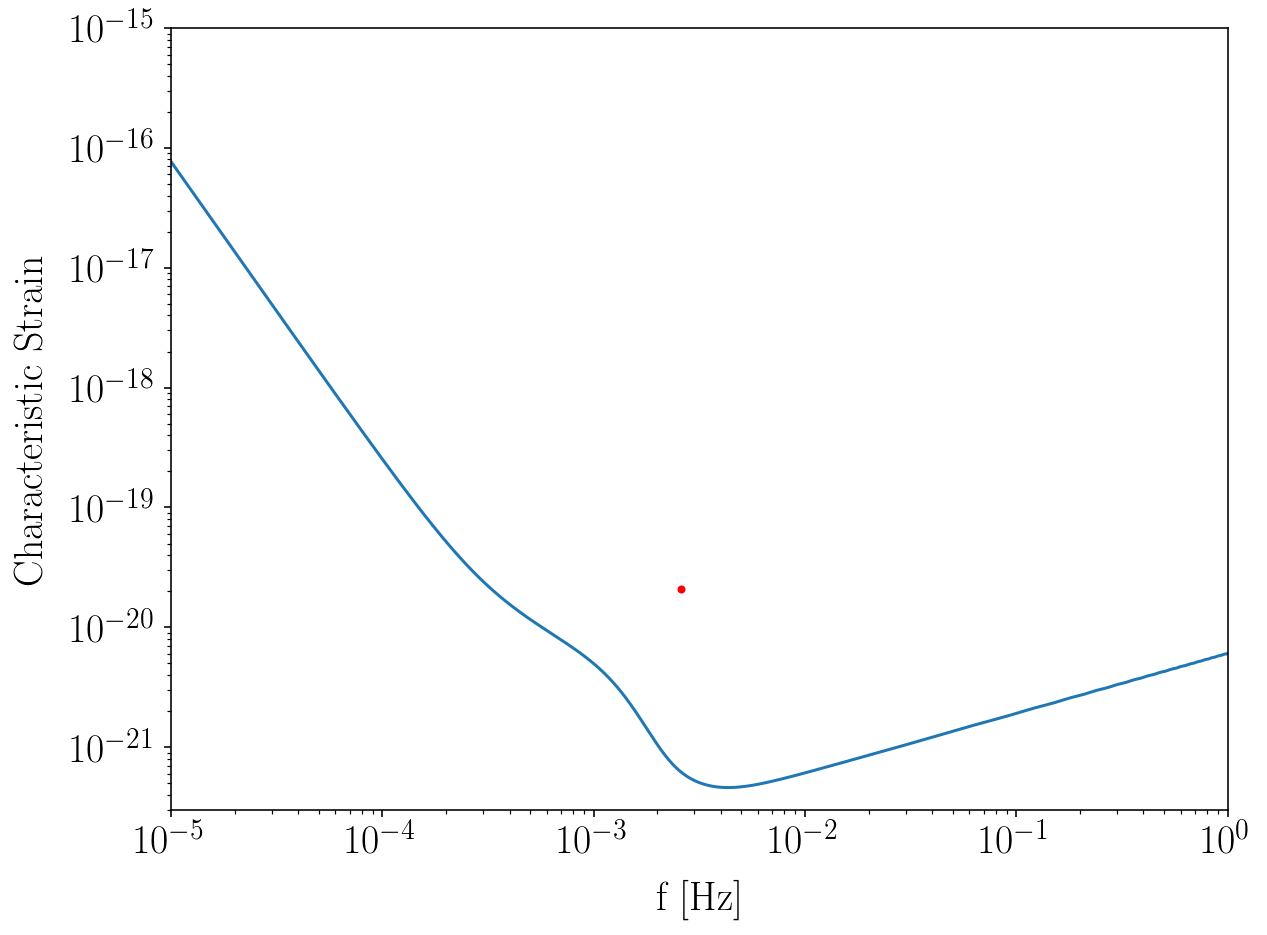

In [10]:
m1 = 0.50*pa.TSUN 
m2 = 0.25*pa.TSUN
Dl = 1.0e-3*wt.MPC
f_start  = 2.6e-3

binary = wt.Binary(m1, m2, Dl=Dl)
binary.f_start = f_start
binary.SetFreqBounds(lisa)

freqs, X_char = binary.CalcStrain(lisa, 1.1, 1.5)
snr = binary.CalcSNR(freqs, X_char, lisa)
print("\nSNR........ {}".format(snr))
binary.PlotStrain(freqs, X_char, lisa)

In [11]:
num = 50
theta_arr = np.linspace(-1, 1, num)
phi_arr = np.linspace(0, 2*np.pi, num)

tot = 0.0

why = np.zeros(num**2)

for i in range(num):
    theta = np.arccos(theta_arr[i])
    for j in range(num):
        phi = phi_arr[j]
        freqs, X_char = binary.CalcStrain(lisa, theta, phi)
        snr = binary.CalcSNR(freqs, X_char, lisa)
        
        tot += snr**2
        
        why[i*num + j] = snr**2

avg_snr = np.sqrt(tot/num**2)
print(avg_snr)

138.839439652392


138.839439652392


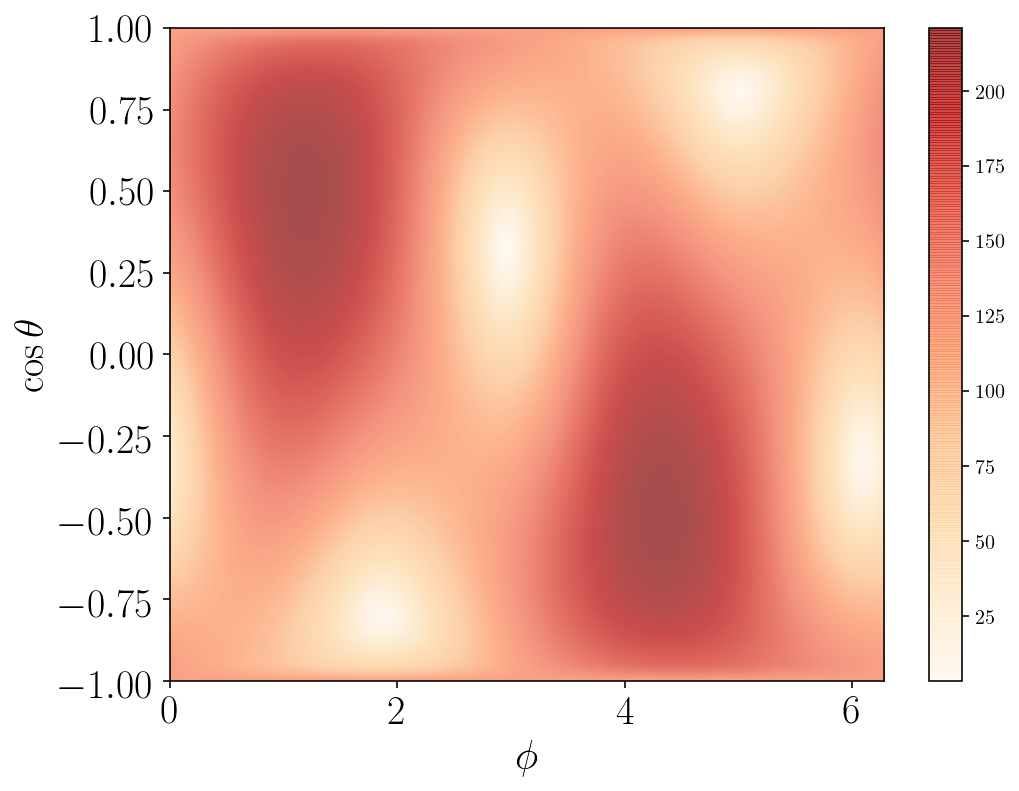

In [12]:
num = 50
theta_arr = np.linspace(-1, 1, num)
phi_arr = np.linspace(0, 2*np.pi, num)

tot = 0.0

data = np.zeros((int(num**2), 3))

for i in range(num):
    theta = np.arccos(theta_arr[i])
    for j in range(num):
        phi = phi_arr[j]
        freqs, X_char = binary.CalcStrain(lisa, theta, phi)
        snr = binary.CalcSNR(freqs, X_char, lisa)
        
        tot += snr**2
        
        data[i*num + j, 0] = theta
        data[i*num + j, 1] = phi
        data[i*num + j, 2] = snr

avg_snr = np.sqrt(tot/num**2)
print(avg_snr)

################

from scipy.interpolate import griddata
import scipy.ndimage as img 
import scipy.interpolate

plt.figure(figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.ylabel(r'$\cos \theta$', fontsize=20)
plt.xlabel(r'$\phi$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)


# FIRST THE FF PLOT
X_dat = data[:,1]
Y_dat = np.cos(data[:,0])
Z_dat = data[:,2]

xi, yi = np.linspace(X_dat.min(), X_dat.max(), 1000), np.linspace(Y_dat.min(), Y_dat.max(), 1000)
xi, yi = np.meshgrid(xi, yi)

zi = scipy.interpolate.griddata((X_dat, Y_dat), Z_dat, (xi, yi), method='cubic')

plt.imshow(zi, vmax=np.max(Z_dat), cmap='OrRd', origin='lower', alpha=0.7, aspect='auto',
               extent=[X_dat.min(), X_dat.max(), Y_dat.min(), Y_dat.max()])

plt.colorbar()
#plt.savefig('example_skyMap.pdf')
plt.show()